In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
data = pd.read_csv('./data/rotten_tomatoes_20200726.csv', 
                            index_col=0,header=0, 
                            encoding = "utf8")
data.head(2)

,text,Action and Adventure,Animation,Art House and International,Comedy,Drama,Horror,Kids and Family,Musical and Performing Arts,Mystery and Suspense,Romance,Science Fiction and Fantasy,fresh,rotten,Other
0,A distinctly gallows take on contemporary fina...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0
1,It's an allegory in search of a meaning that n...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0


In [3]:
y_df = data.iloc[:, 1:]

In [4]:
tags = list(y_df.columns)
tags

['Action and Adventure',
 'Animation',
 'Art House and International',
 'Comedy',
 'Drama',
 'Horror',
 'Kids and Family',
 'Musical and Performing Arts',
 'Mystery and Suspense',
 'Romance',
 'Science Fiction and Fantasy',
 'fresh',
 'rotten',
 'Other']

In [5]:
Y = y_df.values
Y[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.]])

In [6]:
num_tags = y_df.shape[1]
num_tags

14

# Load Processed Data

In [7]:
import pickle

file_path = './data/rt-processed.pickle'
with open(file_path, 'rb') as pickle_file:
    text_train = pickle.load(pickle_file)
    y_train = pickle.load(pickle_file)
    text_test = pickle.load(pickle_file)
    y_test = pickle.load(pickle_file)
#     comedydramafresh = pickle.load(pickle_file)

In [8]:
review_text = pd.concat([text_train,text_test])

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_text)

/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tao/anaconda3/envs/tf_gpu/lib/python3.7/site-pack

In [10]:
VOCAB_SIZE = len(tokenizer.word_index) + 1 #19793
EMBED_DIM = 100
#MAX_LENGTH = review_text.apply(len).max()

In [11]:
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

X_train_pad = pad_sequences(X_train, maxlen=75, padding = 'post')
X_test_pad = pad_sequences(X_test, maxlen=75, padding = 'post')

X_train_pad.shape, X_test_pad.shape

((39004, 75), (9751, 75))

In [12]:
# exp_test = tokenizer.texts_to_sequences(comedydramafresh)
# exp_test_pad = pad_sequences(exp_test, maxlen=MAX_LENGTH, padding = 'post')
# exp_test_pad.shape

In [13]:
import os
import numpy as np

GLOVE_DIR = '../spam_2019/data/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix.min()

-3.6791999340057373

In [17]:
embedding_matrix.max()

3.030400037765503

use ``exp`` to convert all values to be _positive_.

In [41]:
embedding_matrix_pos = np.exp(embedding_matrix)

embedding_matrix_pos.min()

0.025243162954504007

In [19]:
X_train[0]

[2227,
 95,
 47,
 2059,
 336,
 15,
 187,
 215,
 2049,
 5602,
 142,
 41,
 5139,
 515,
 294,
 1812,
 2725,
 198,
 39]

In [42]:
def globe_emb(train_array, emb_dim=100):
    emb_matrix = []
    for x in train_array:
        embs = []
        embs += [embedding_matrix_pos[i] for i in x]
        embs = np.array(embs)
        X_train_emb0 = embs.mean(axis=0)
#         X_train_emb0 = np.sum(embs,axis=0)    
        emb_matrix.append(X_train_emb0)
    emb_matrix = np.array(emb_matrix)
    return emb_matrix

In [43]:
train_matrix = globe_emb(X_train)
test_matrix = globe_emb(X_test)

In [44]:
train_matrix.shape

(39004, 100)

In [45]:
train_matrix[0]

array([0.86069929, 1.23174669, 1.20346478, 0.94122323, 0.90858472,
       1.47890169, 0.8592531 , 1.15696407, 1.08587607, 0.87025648,
       1.01373839, 1.09062541, 1.12491539, 1.11769233, 1.14096291,
       1.0276852 , 1.04240092, 1.18958171, 1.13541855, 1.17806457,
       1.11606643, 1.06772104, 0.90886101, 0.95946864, 1.27004532,
       1.17666196, 0.89143998, 0.94119777, 1.38491604, 0.87978035,
       1.06230751, 1.42024887, 1.05298297, 1.09208708, 1.04019493,
       1.14293405, 0.87278657, 1.07374573, 1.34979662, 0.87300056,
       0.95734934, 0.92810643, 0.9774824 , 0.72485201, 0.84325242,
       1.11091243, 1.00311042, 1.07596446, 0.97579612, 0.73233561,
       1.13054484, 0.9731426 , 1.11383962, 1.93733315, 1.03799813,
       0.57892729, 1.09648681, 0.9890271 , 2.74974512, 1.10228316,
       1.14552501, 1.89411608, 0.84258665, 1.0472385 , 1.3828256 ,
       1.16036385, 1.32774928, 1.29630614, 0.90395152, 0.8774412 ,
       1.17435529, 0.99475219, 1.13657929, 0.86266645, 1.16671

In [46]:
assert train_matrix.shape[0] == len(X_train)
assert test_matrix.shape[0] == len(X_test)

In [47]:
train_matrix.shape, test_matrix.shape

((39004, 100), (9751, 100))

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [49]:
model = Sequential()
#model.add(Input(shape=(100,)))
model.add(Dense(128, activation='relu', input_shape=(100,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_tags, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 14)                462       
Total params: 89,646
Trainable params: 89,646
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(train_matrix, y_train,
          batch_size=32,
          epochs=50,
          validation_split=0.1)

print('Eval loss/accuracy:{}'.format(model.evaluate(test_matrix, y_test, batch_size = 32)))

Train on 35103 samples, validate on 3901 samples
Epoch 1/50
35103/35103 [==============================] - 8s 229us/sample - loss: 0.4304 - acc: 0.8053 - val_loss: 0.4037 - val_acc: 0.8118
Epoch 2/50
35103/35103 [==============================] - 8s 220us/sample - loss: 0.3946 - acc: 0.8184 - val_loss: 0.3800 - val_acc: 0.8252
Epoch 3/50
35103/35103 [==============================] - 8s 219us/sample - loss: 0.3742 - acc: 0.8278 - val_loss: 0.3781 - val_acc: 0.8286
Epoch 4/50
35103/35103 [==============================] - 8s 219us/sample - loss: 0.3653 - acc: 0.8320 - val_loss: 0.3551 - val_acc: 0.8370
Epoch 5/50
35103/35103 [==============================] - 8s 219us/sample - loss: 0.3551 - acc: 0.8378 - val_loss: 0.3542 - val_acc: 0.8387
Epoch 6/50
35103/35103 [==============================] - 8s 223us/sample - loss: 0.3456 - acc: 0.8421 - val_loss: 0.3417 - val_acc: 0.8412
Epoch 7/50
35103/35103 [==============================] - 8s 219us/sample - loss: 0.3339 - acc: 0.8481 - val_lo

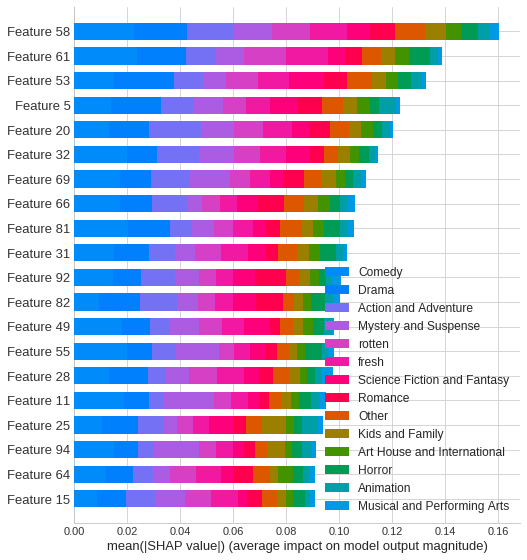

In [96]:
import shap

attrib_data = train_matrix[:15000]
explainer = shap.DeepExplainer(model, attrib_data)
num_explanations = 3000
shap_vals = explainer.shap_values(test_matrix[:num_explanations])

shap.summary_plot(shap_vals, class_names=y_df.columns)

In [97]:
type(shap_vals)

list

In [98]:
len(shap_vals)

14

In [99]:
len(shap_vals[0])

3000

In [100]:
len(shap_vals[0][0])

100

``shap_vals`` has a shape of $c \times m \times k$, in which:
- $c$ is the # of classes (e.g. `14`);
- $m$ is the # of test instances in SHAP (e.g. `200`);
- $k$ is the # of features (e.g. `100`).

Action and Adventure


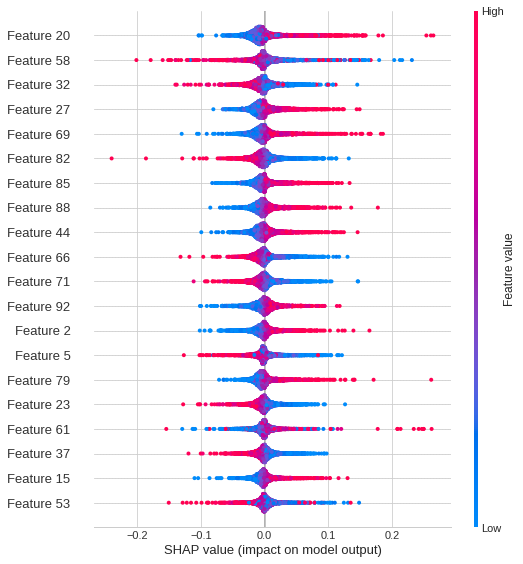

Animation


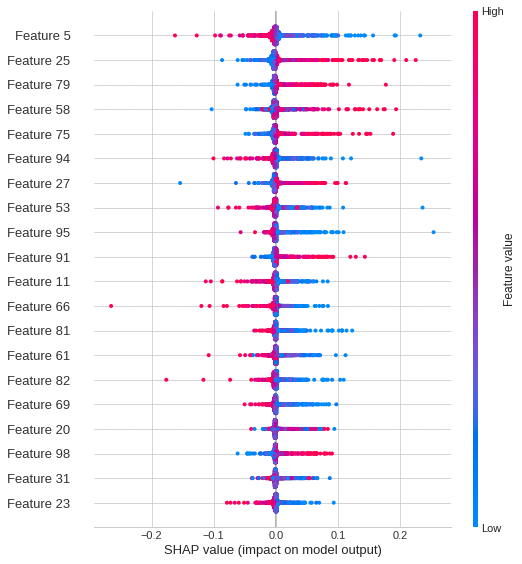

Art House and International


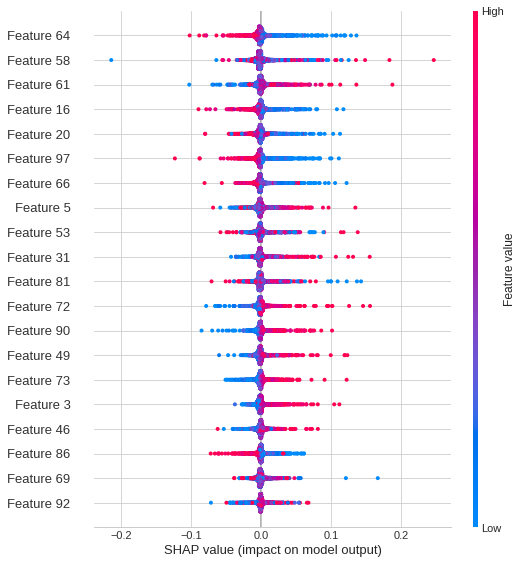

Comedy


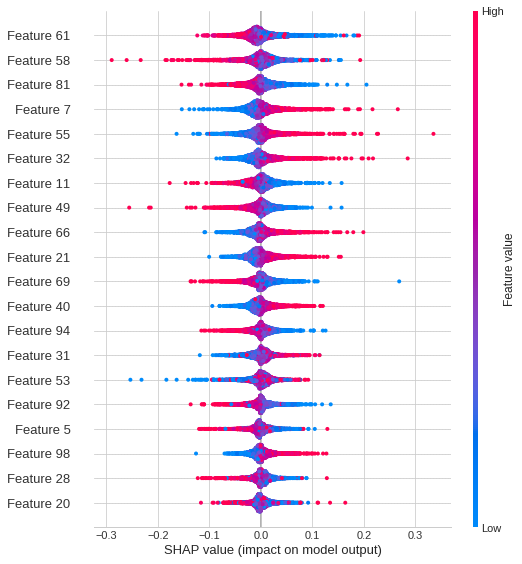

Drama


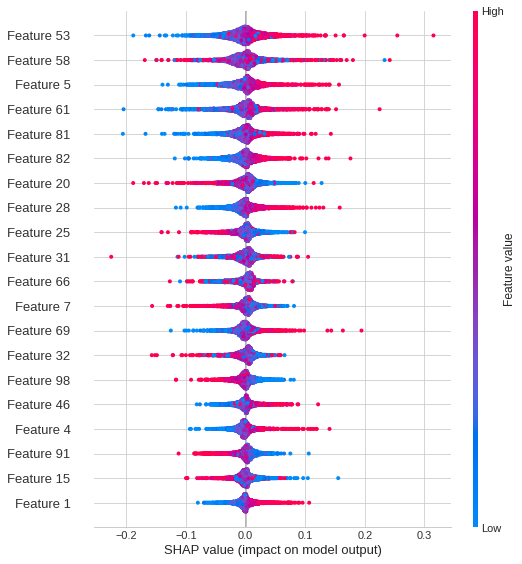

Horror


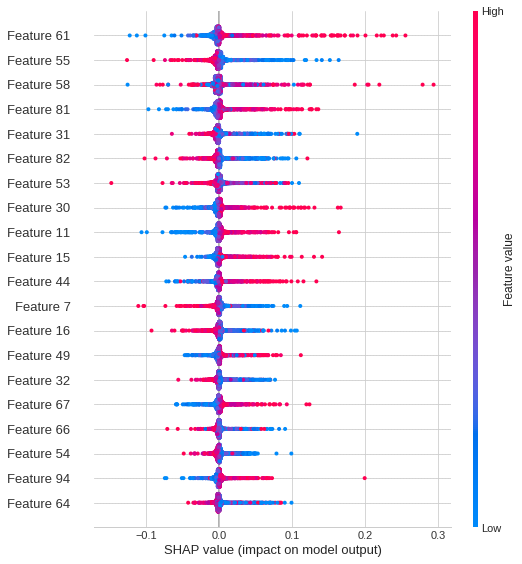

Kids and Family


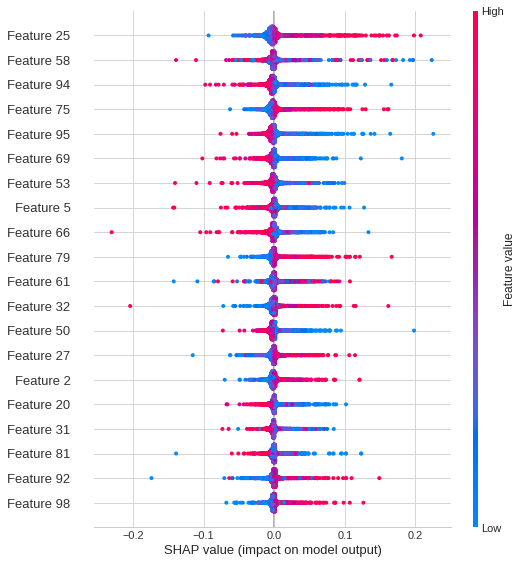

Musical and Performing Arts


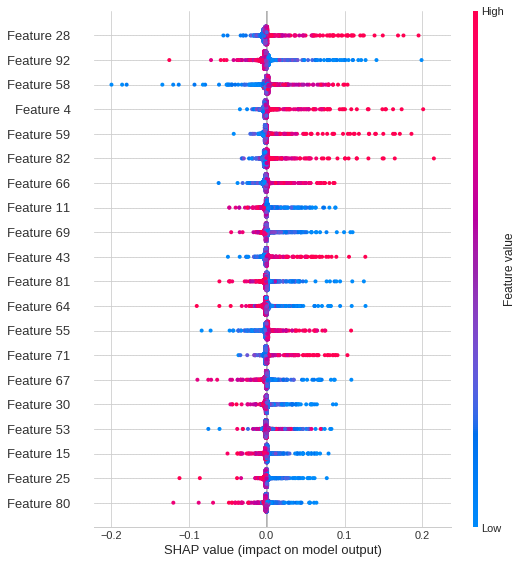

Mystery and Suspense


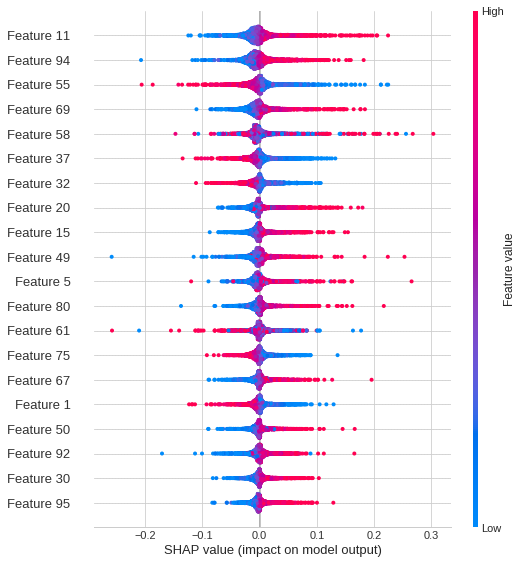

Romance


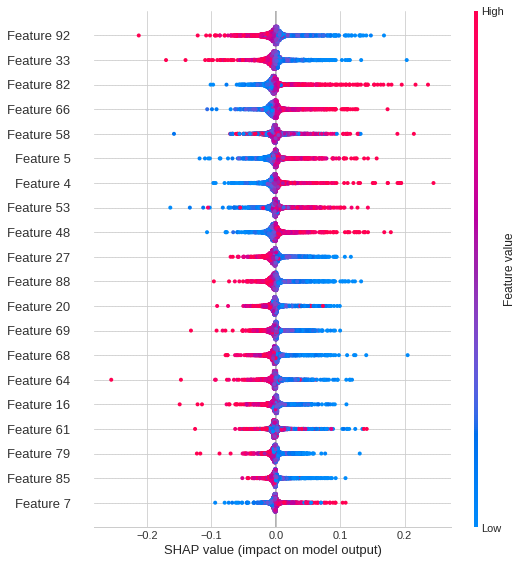

Science Fiction and Fantasy


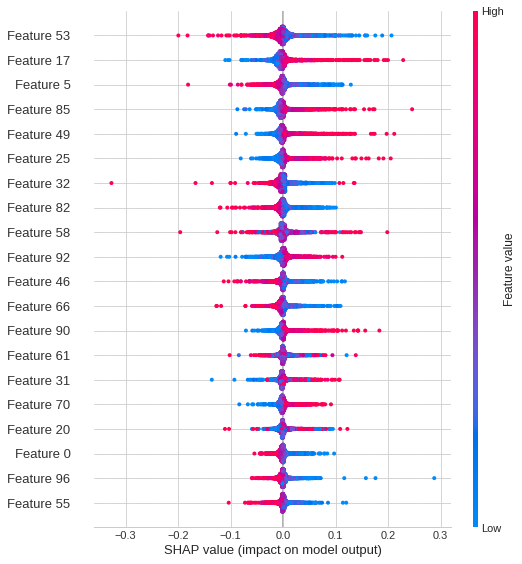

fresh


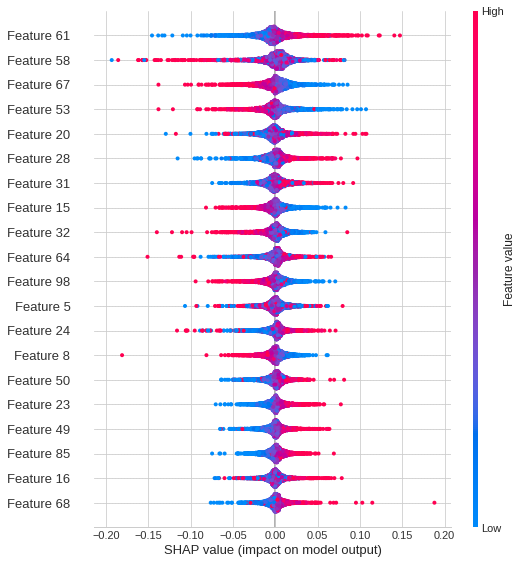

rotten


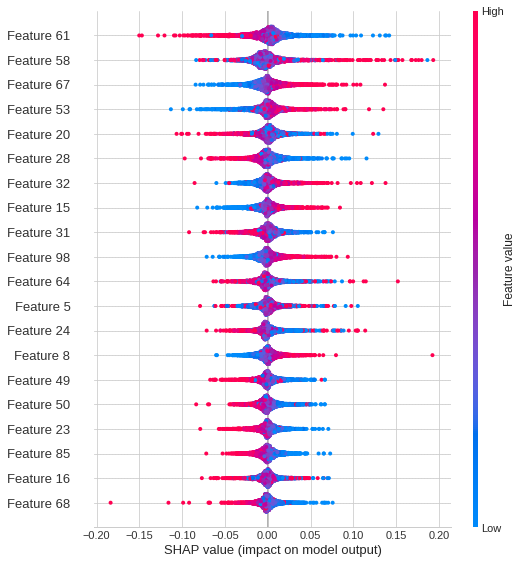

Other


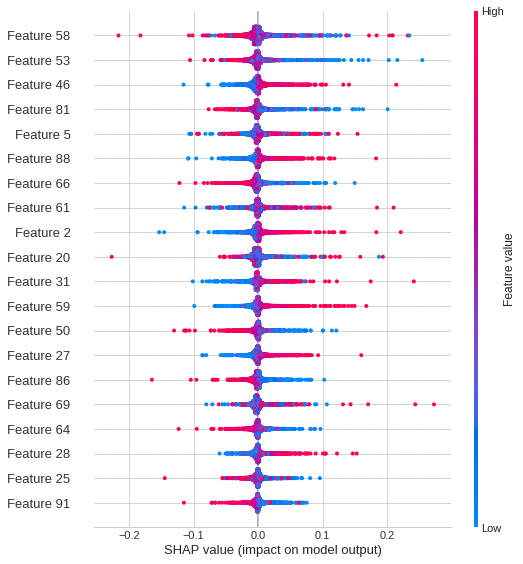

In [101]:
for i in range(14):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals[i], test_matrix[:num_explanations])

In [102]:
shap_vals_arr = np.array(shap_vals)
shap_vals_arr.shape

(14, 3000, 100)

average by $m$ to get the global feature importances

In [103]:
shap_vals_global = shap_vals_arr.mean(axis=1)
shap_vals_global.shape

(14, 100)

In [104]:
test_voc = []
for x in X_test[:num_explanations]:
    test_voc.extend(x)
    
test_voc = list(set(test_voc))
len(test_voc)

8570

In [105]:
test_embedding_matrix = embedding_matrix_pos[test_voc]
test_embedding_matrix.shape

(8570, 100)

In [106]:
shap_class_word = np.dot(shap_vals_global, test_embedding_matrix.T)
shap_class_word.shape

(14, 8570)

In [107]:
idx = np.argpartition(shap_class_word[0], -10)[-10:]
sorted_idx = idx[np.argsort(shap_class_word[0][idx])]

word_lookup = {v:k for k,v in tokenizer.word_index.items()}

for i in sorted_idx:
    print(word_lookup[i])

zealous
theater
mountain
histori
angst
challeng
appropri
poignant
polici
eleg


In [108]:
word_lookup = {v:k for k,v in tokenizer.word_index.items()}

for i in range(len(tags)):
    print(tags[i])
    print('\n')
    idx = np.argpartition(shap_class_word[i], -20)[-20:]
    sorted_idx = idx[np.argsort(shap_class_word[i][idx])]

    

    for j in sorted_idx:
        print(word_lookup[j])
        
    #break
    print('\n')

Action and Adventure


hover
substant
joy
destroy
conductor
creativ
heffalump
seller
miser
innoc
zealous
theater
mountain
histori
angst
challeng
appropri
poignant
polici
eleg


Animation


quiet
persononc
insur
lick
overlap
earthl
milagro
unarm
grisli
notion
unnam
slipperi
skull
player
shower
rent
rowan
personbrief
illegitim
psychedel


Art House and International


philosophi
short
mountain
new
sort
destroy
massiv
protract
substant
seller
affection
sausag
streetcar
polici
atroci
histori
cliquish
angst
eleg
appropri


Comedy


inch
esqu
nerv
fever
toni
caustic
oblig
bloodsh
william
luckili
effac
debut
gawki
brad
stinker
evolv
fastidi
theori
volcan
psychedel


Drama


program
crow
veteran
talk
reunit
newlyw
director
restor
polici
luscious
massiv
fait
cost
produc
atroci
appropri
sort
angst
sausag
protract


Horror


spotti
entertain
electrifi
conehead
licens
afterlif
grim
separ
orgwho
industri
parti
personar
give
cardin
later
grander
sensuous
near
personinfam
convey


Kids and Family


h

In [110]:
for i in range(len(tags)):
    print(tags[i])
    print('\n')
    idx = np.argpartition(shap_class_word[i], 20)[:20]
    sorted_idx = idx[np.argsort(shap_class_word[i][idx])]

    

    for j in sorted_idx:
        print(word_lookup[j])
        
    #break
    print('\n')

Action and Adventure


unwav
turnov
wrangl
turgid
meat
toddler
left
fastidi
secretari
spotti
flavour
newcom
truli
bloodsh
treacl
personheld
rewrit
squander
videogam
unapp


Animation


seen
lifeboat
brad
shawkat
safeti
flutter
dual
armi
evolv
guest
cutesi
sunshin
nation
desper
bookend
j
singleton
jaunt
von
sensat


Art House and International


player
personbrief
notion
partnership
luckili
rent
snatch
unearth
gisell
much
cecil
shower
chicken
fever
treac
wretch
appl
fashicardinald
personjeff
beset


Comedy


challeng
angst
eleg
mountain
heffalump
polici
rise
appropri
creativ
conductor
histori
innoc
theater
casino
fast
substant
joke
diesel
destroy
peac


Drama


psychedel
unarm
rambuncti
dennehi
stolen
slipperi
volcan
expos
odd
main
sizabl
acquir
crucifixion
smatter
black
piglet
notion
later
edi
intercut


Horror


polici
angst
slimi
histori
innoc
poignant
eleg
seller
zealous
destruct
appropri
entri
destroy
short
tabloid
massiv
thug
aw
airless
play


Kids and Family


rewrit
later
guest


In [66]:
embedding_matrix.shape

(19793, 100)

In [67]:
np.argmax(embedding_matrix[55])

20

In [73]:
#np.argpartition(embedding_matrix[55], -5)[-5:]
idx = np.argpartition(embedding_matrix[55], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[55][idx])]

In [74]:
word_lookup = {v:k for k,v in tokenizer.word_index.items()}

for i in sorted_idx:
    print(word_lookup[i])

littl
personand
woman
place
town
work
action
coupl
go
father
meet
becom
adapt
see
follow
old
big
life
perform
find


In [75]:
idx = np.argpartition(embedding_matrix[55], 20)[:20]
sorted_idx = idx[np.argsort(embedding_matrix[55][idx])]
for i in sorted_idx:
    print(word_lookup[i])

take
person
home
novel
persona
boy
new
inspir
world
true
way
start
power
group
norp
even
personth
look
tale
base


In [76]:
idx = np.argpartition(embedding_matrix[11], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[11][idx])]
for i in sorted_idx:
    print(word_lookup[i])

perform
drama
group
good
becom
team
town
date
set
end
return
world
help
personi
look
thriller
come
even
award
love


In [64]:
idx = np.argpartition(embedding_matrix[49], -5)[-5:]
sorted_idx = idx[np.argsort(embedding_matrix[49][idx])]
for i in sorted_idx:
    print(word_lookup[i])

even
good
award
world
town


In [44]:
idx = np.argpartition(embedding_matrix[71], -5)[-5:]
sorted_idx = idx[np.argsort(embedding_matrix[71][idx])]
for i in sorted_idx:
    print(word_lookup[i])

direct
team
good
even
award


In [45]:
idx = np.argpartition(embedding_matrix[49], -5)[-5:]
sorted_idx = idx[np.argsort(embedding_matrix[49][idx])]
for i in sorted_idx:
    print(word_lookup[i])

even
good
award
world
town


In [46]:
idx = np.argpartition(embedding_matrix[50], -5)[-5:]
sorted_idx = idx[np.argsort(embedding_matrix[50][idx])]
for i in sorted_idx:
    print(word_lookup[i])

good
org
award
town
even


In [47]:
shap_vals[0].shape

(100, 100)

Action and Adventure


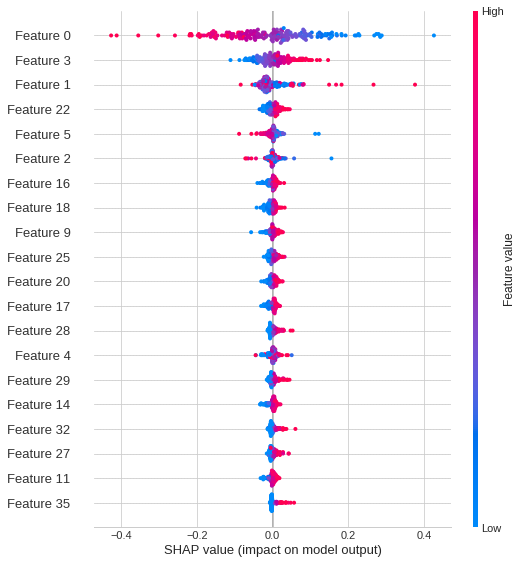

Animation


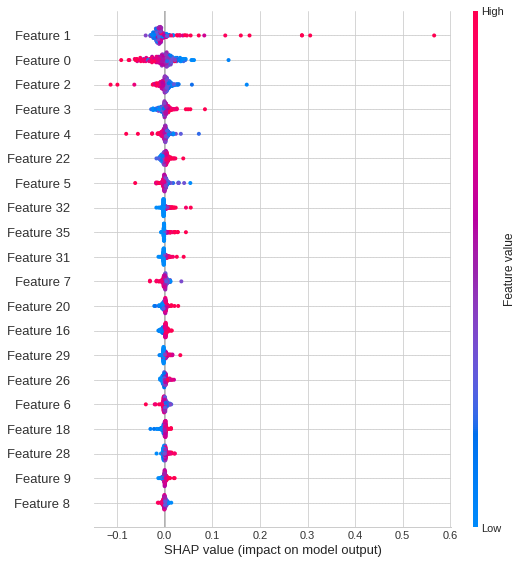

Art House and International


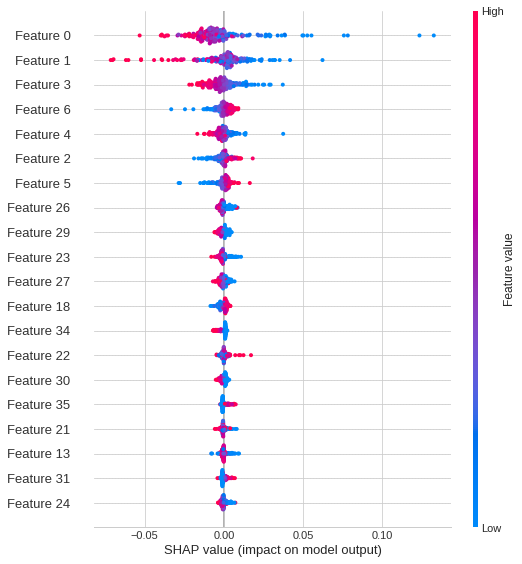

Comedy


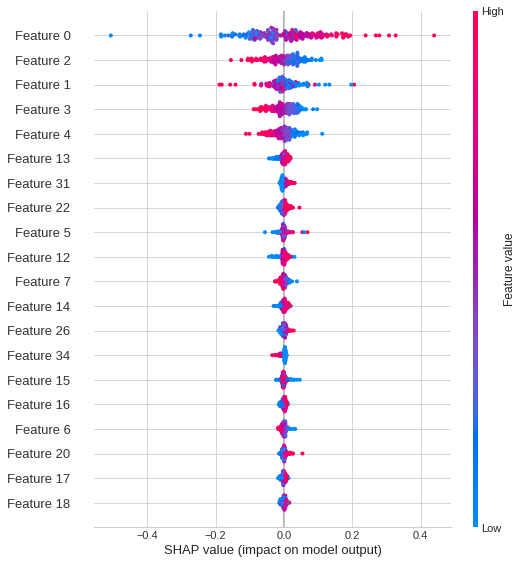

Drama


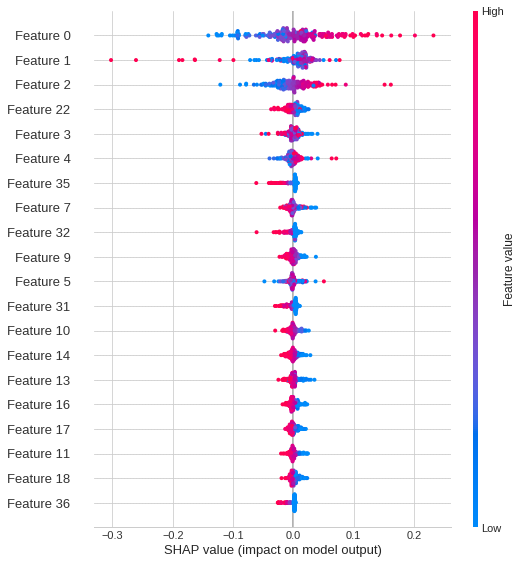

Horror


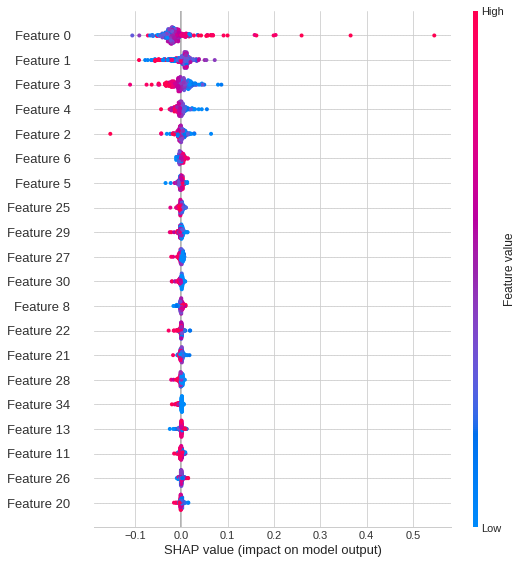

Kids and Family


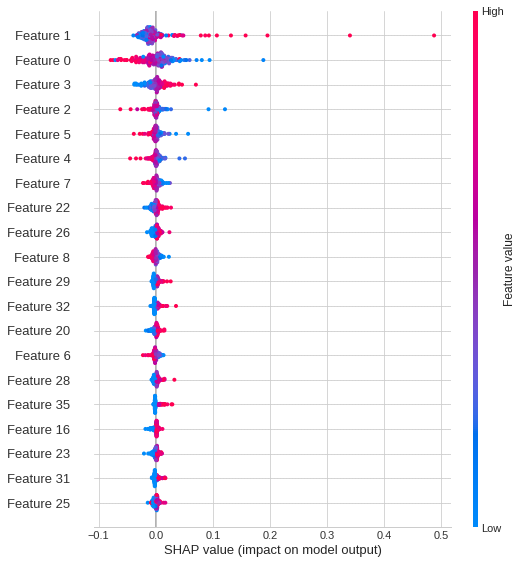

Musical and Performing Arts


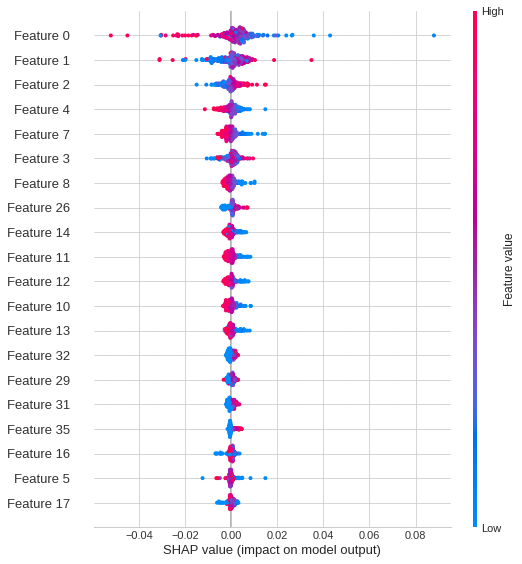

Mystery and Suspense


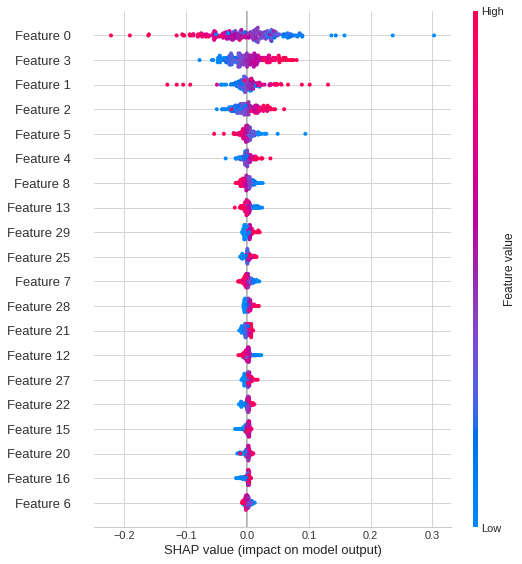

Romance


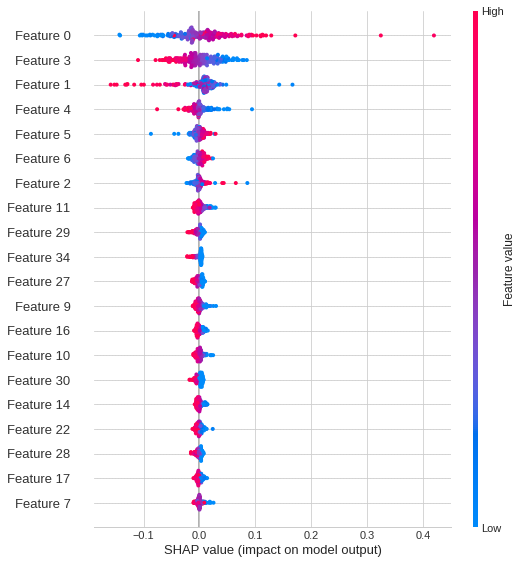

Science Fiction and Fantasy


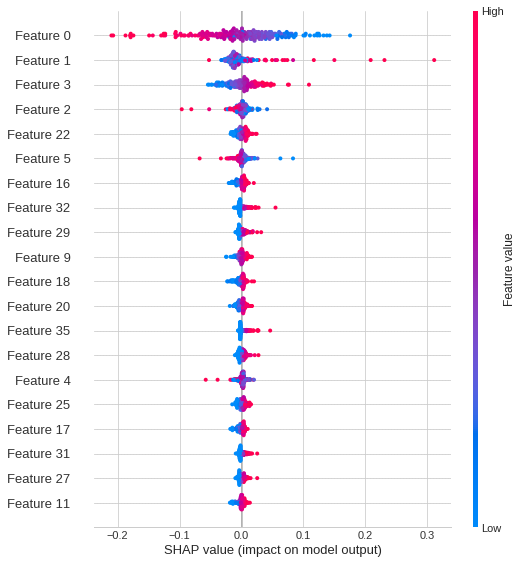

fresh


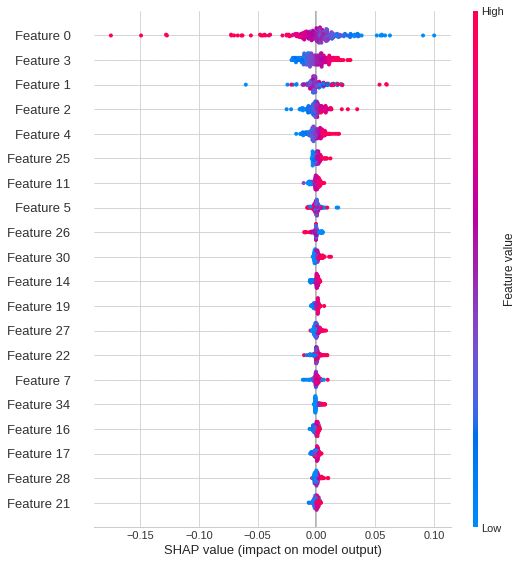

rotten


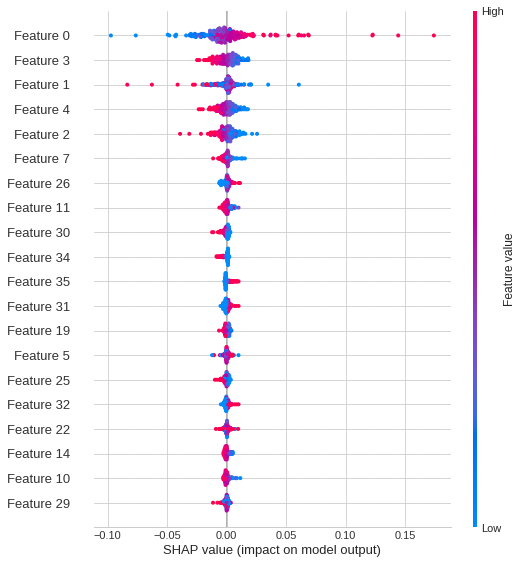

Other


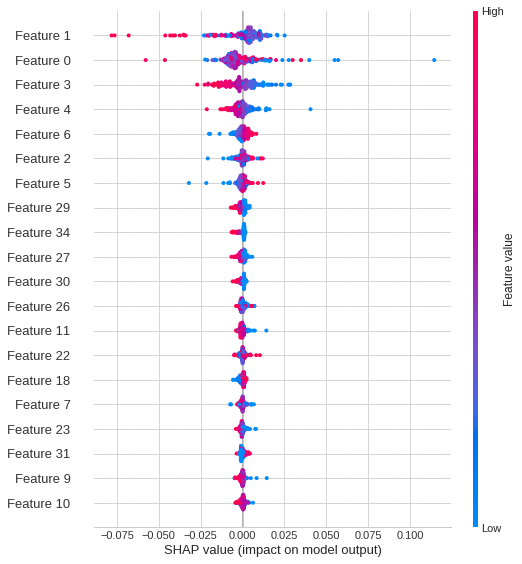

In [71]:
for i in range(14):
    print(y_df.columns[i])
    shap.summary_plot(shap_vals[i], test_matrix_pad[:num_explanations])

In [93]:
# init the JS visualization code
shap.initjs()
# create dict to invert word_idx k,v order
input_num = 30
# num2word = {}
# for w in tokenizer.word_index.keys():
#     num2word[tokenizer.word_index[w]] = w
# x_test_words = X_test[:num_explanations][30]

# plot the explanation of a given prediction
class_num = 0

print(tags[0])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Action and Adventure


In [94]:
# plot the explanation of a given prediction
class_num = 1

print(tags[1])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Animation


In [95]:
# plot the explanation of a given prediction
class_num = 2

print(tags[2])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Art House and International


In [96]:
# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [97]:
# plot the explanation of a given prediction
class_num = 4

print(tags[4])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Drama


In [99]:
# init the JS visualization code
shap.initjs()
# create dict to invert word_idx k,v order
input_num = 20

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [100]:
input_num = 10

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [101]:
input_num = 10

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 4

print(tags[4])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Drama


In [102]:
input_num = 5

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [103]:
input_num = 5

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [105]:
input_num = 50

num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][input_num]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

# plot the explanation of a given prediction
class_num = 3

print(tags[3])
shap.force_plot(explainer.expected_value[class_num], shap_vals[class_num][input_num], x_test_words)

Comedy


In [84]:
tokenizer.word_index.keys()

dict_keys(['person', 'date', 'gpe', 'cardin', 'film', 'norp', 'org', 'stori', 'time', 'movi', 'star', 'life', 'comedi', 'young', 'make', 'love', 'take', 'director', 'world', 'find', 'ordin', 'live', 'man', 'come', 'drama', 'like', 'work', 'famili', 'persona', 'friend', 'get', 'follow', 'way', 'set', 'new', 'high', 'becom', 'direct', 'back', 'adventur', 'woman', 'play', 'base', 'thriller', 'action', 'home', 'charact', 'end', 'best', 'begin', 'adapt', 'much', 'town', 'novel', 'loc', 'forc', 'return', 'even', 'look', 'personperson', 'award', 'personand', 'peopl', 'good', 'old', 'personi', 'team', 'littl', 'help', 'hes', 'tell', 'coupl', 'power', 'wife', 'true', 'group', 'meet', 'screen', 'personwho', 'featur', 'boy', 'beauti', 'personth', 'tale', 'big', 'start', 'turn', 'school', 'place', 'girl', 'perform', 'inspir', 'name', 'go', 'see', 'death', 'father', 'run', 'romant', 'well', 'ever', 'never', 'doesnt', 'move', 'mani', 'mother', 'fall', 'discov', 'real', 'want', 'mysteri', 'anim', 'gr

In [92]:
num2word = {}
for w in tokenizer.word_index.keys():
    num2word[tokenizer.word_index[w]] = w
# x_test_words = [num2word[i] for i in X_test_pad[:num_explanations][30]]

x_test_words = []
for i in X_test_pad[:num_explanations][30]:
    if i in num2word.keys():
        x_test_words.append(num2word[i])
    else:
        x_test_words.append('UNK')

In [87]:
num2word[891]

'rare'

In [79]:
test_matrix[:num_explanations][30]

array([ 3.42608027e+02,  6.51799673e+01,  5.55267851e+01,  4.37084533e+01,
        4.09598294e+01,  3.93114527e+01,  3.63895976e+01,  2.99041186e+01,
        2.81335526e+01,  2.70181219e+01,  2.58895110e+01,  2.53863039e+01,
        2.33979128e+01,  2.07440981e+01,  1.86073231e+01,  1.70446434e+01,
        1.55168737e+01,  1.40652323e+01,  1.32036207e+01,  1.18196623e+01,
        1.11905159e+01,  1.02954188e+01,  9.31000333e+00,  2.12688172e+00,
        2.92321301e+00,  3.66847517e+00,  7.86011243e+00,  7.29496119e+00,
        7.04540551e+00,  6.38256382e+00,  5.29345024e+00,  5.01587559e+00,
        4.71164279e+00,  4.46454726e-15, -6.17446811e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [80]:
X_test[:num_explanations][30]

[891,
 384,
 139,
 10,
 891,
 7161,
 3352,
 1523,
 4999,
 454,
 193,
 16,
 3168,
 287,
 976,
 85,
 78,
 80,
 51,
 337,
 568,
 1,
 118,
 29,
 454,
 14,
 232,
 91,
 2589,
 441,
 885,
 320,
 2811,
 1748,
 698,
 241,
 321,
 1298,
 4,
 3671,
 2027,
 3633,
 15,
 686]

In [81]:
test_matrix[:num_explanations][30].shape

(44,)

In [83]:
len(X_test[:num_explanations][30])

44

In [78]:
# action and adventure
idx = np.argpartition(embedding_matrix[25], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[25][idx])]
for i in sorted_idx:
    print(word_lookup[i])

end
much
look
like
romant
death
even
name
director
beauti
true
thriller
good
power
comedi
world
help
come
town
award


In [79]:
idx = np.argpartition(embedding_matrix[25], 20)[:20]
sorted_idx = idx[np.argsort(embedding_matrix[25][idx])]
for i in sorted_idx:
    print(word_lookup[i])


loc
tale
play
start
man
peopl
featur
place
begin
friend
stori
wife
personwho
ordin
personand
old
follow
charact
life
young


In [80]:
idx = np.argpartition(embedding_matrix[69], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[69][idx])]
for i in sorted_idx:
    print(word_lookup[i])

meet
way
littl
person
award
good
love
boy
action
novel
old
get
wife
hes
world
team
turn
featur
town
even


In [81]:
idx = np.argpartition(embedding_matrix[69], 20)[:20]
sorted_idx = idx[np.argsort(embedding_matrix[69][idx])]
for i in sorted_idx:
    print(word_lookup[i])

loc
tale
base
name
director
return
best
power
school
begin
help
tell
work
screen
beauti
adventur
like
norp
coupl
go


In [83]:
idx = np.argpartition(embedding_matrix[53], -15)[-15:]
sorted_idx = idx[np.argsort(embedding_matrix[53][idx])]
for i in sorted_idx:
    print(word_lookup[i])

good
org
even
world
follow
girl
award
school
film
father
group
run
find
town
love


In [84]:
idx = np.argpartition(embedding_matrix[53], 15)[:15]
sorted_idx = idx[np.argsort(embedding_matrix[53][idx])]
# for i in sorted_idx:
#     print(word_lookup[i])
# idx, sorted_idx
embedding_matrix[32][idx]

array([-1.81239998, -0.47856   , -0.35782999,  0.037125  , -0.039147  ,
       -0.24459   ,  0.15981001,  0.14618   ,  0.57814997, -0.66131997,
        0.31762001, -0.6954    ,  0.059977  , -0.16384   ,  0.087095  ])

In [85]:
embedding_matrix[53][sorted_idx]

array([-2.59529996, -1.34519994, -1.30190003, -1.03349996, -0.92786998,
       -0.84671003, -0.82709998, -0.79211998, -0.77419001, -0.74523997,
       -0.69272   , -0.66566002, -0.65377003, -0.63222998, -0.60657001])

In [86]:
for i in sorted_idx:
    print(word_lookup[i])

loc
forc
go
come
drama
return
screen
novel
begin
power
famili
director
turn
woman
make


In [87]:
idx = np.argpartition(embedding_matrix[7], -15)[-15:]
sorted_idx = idx[np.argsort(embedding_matrix[71][idx])]
for i in sorted_idx:
    print(word_lookup[i])

best
man
beauti
go
littl
perform
way
look
life
old
inspir
stori
get
movi
even


In [88]:
idx = np.argpartition(embedding_matrix[7], 15)[:15]
sorted_idx = idx[np.argsort(embedding_matrix[71][idx])]
for i in sorted_idx:
    print(word_lookup[i])

power
gpe
boy
persona
home
help
find
high
novel
return
turn
wife
org
true
girl


In [76]:
idx = np.argpartition(embedding_matrix[7], -30)[-30:]
sorted_idx = idx[np.argsort(embedding_matrix[7][idx])]
for i in sorted_idx:
    print(word_lookup[i])

personi
start
woman
friend
charact
new
ordin
school
personth
direct
hes
tale
forc
norp
film
old
even
perform
stori
inspir
life
get
go
look
beauti
way
movi
man
best
littl


In [92]:
# comedy
idx = np.argpartition(embedding_matrix[81], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[81][idx])]
for i in sorted_idx:
    if i in word_lookup.keys():
        print(word_lookup[i])
    else:
        print('UNK')

date
follow
love
way
young
life
end
look
personi
direct
personperson
world
drama
UNK
even
film
award
true
town
persona


In [93]:
# comedy
idx = np.argpartition(embedding_matrix[81], 20)[:20]
sorted_idx = idx[np.argsort(embedding_matrix[81][idx])]
for i in sorted_idx:
    if i in word_lookup.keys():
        print(word_lookup[i])
    else:
        print('UNK')

loc
tale
like
work
romant
death
home
high
forc
base
personwho
back
personand
big
screen
gpe
movi
turn
littl
go


In [94]:
# comedy
idx = np.argpartition(embedding_matrix[40], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[40][idx])]
for i in sorted_idx:
    if i in word_lookup.keys():
        print(word_lookup[i])
    else:
        print('UNK')

play
famili
persona
friend
get
follow
way
set
new
like
becom
end
back
charact
home
action
high
direct
work
romant


In [95]:
# drama
idx = np.argpartition(embedding_matrix[55], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[55][idx])]
for i in sorted_idx:
    print(word_lookup[i])

littl
personand
woman
place
town
work
action
coupl
go
father
meet
becom
adapt
see
follow
old
big
life
perform
find


In [96]:
# drama
idx = np.argpartition(embedding_matrix[5], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[5][idx])]
for i in sorted_idx:
    print(word_lookup[i])

come
get
much
director
high
personi
team
make
power
good
love
base
help
cardin
thriller
return
town
even
world
award


In [97]:
# drama
idx = np.argpartition(embedding_matrix[67], -20)[-20:]
sorted_idx = idx[np.argsort(embedding_matrix[67][idx])]
for i in sorted_idx:
    print(word_lookup[i])

org
movi
famili
boy
love
wife
good
run
featur
date
name
play
norp
help
get
even
team
town
becom
look


In [88]:
# romance
idx = np.argpartition(embedding_matrix[88], -10)[-10:]
sorted_idx = idx[np.argsort(embedding_matrix[88][idx])]
for i in sorted_idx:
    if i != 0:
        print(word_lookup[i])

love
live
get
name
help
comedi
org
time
even
